# Homework 3: Dynamic Programming

In this assignment you will implement the *value iteration* algorithm and apply it to the Frozen Lake and Gambler's environments.  Before submitting your solution, **make sure** your notebook compiles entirely, from scratch (i.e. use the Kernel->"Restart and Run All" option).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

import random

plt.style.use('ggplot')

### Excerise 1 (10 Points):

Implement value iteration for the gambler's problem, detailed below.

#### Gambler's Environment

This exercise uses the Gambler's Problem detailed in Example 4.3 in [SB](http://incompleteideas.net/book/the-book-2nd.html). The important details are described here:

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of \$100, or loses by running out of money. On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars.

This problem can be formulated as an undiscounted, episodic, finite MDP. The state is the gambler’s capital, $s\in\{1,2,...,99\}$ and the actionsare stakes, $a\in\{0,1,...,\min(s,100 - s)\}$. The reward is zero on all transitions except those on which the gambler reaches his goal, when it is $+1$. The state-value function then gives the probability of winning from each state.  A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. Let $p_h$ denote the probability of the coin coming up heads. If $p_h$ is known, then the entire problem is known and it can be solved, for instance, by value iteration.  Figure 4.3 shows the change in the value function over successive sweeps of value iteration, and the final policy found, for the case of $p_h=0.4$. This policy is optimal, but not unique. In fact, there is a whole family of optimal policies, all corresponding to ties for the argmax action selection with respect to the optimal value function. Can you guess what the entire family looks like?

In [13]:
def gamblers_possible_actions(s):
    """
    Args:
        s: Current state, i.e. amount of money available
    Returns:
        An iterable of actions which can be taken from that state
    """
    return range(1, min(s, 100 - s) + 1)
    
    
def gamblers_value_iteration(p_h, theta=1e-4, gamma=1.0):
    """
    Args:
        p_h: Probability of coin flip being heads
        theta: Threshold used to determine accuracy of estimation
        gamma: Discount factor
    Returns:
        A tuple (value function, policy)
    """

    V = np.zeros(101)
    policy = np.zeros(100, dtype=np.int)

    # YOUR CODE HERE
    while(True):
        delta = 0
        for s in range(1, 100):
            v = V[s]
            possible_actions = gamblers_possible_actions(s)
            best_return = 0
            for action in possible_actions:
                
                # HEAD -> win all the stakes
                next_state_head = s + action
                r_head = 0
                if (next_state_head >= 100):
                    r_head = 1
                else:
                    r_head = 0
                    
                # TAIL    
                next_state_tail = s - action
                if (next_state_tail >= 100):
                    r_tail = 1
                else:
                    r_tail = 0                 
                               
                current_return = p_h * (r_head + gamma * V[next_state_head]) + (1 - p_h) * (r_tail + gamma * V[next_state_tail])

                if (current_return >= best_return):
                    best_return = current_return
            
            V[s] = best_return
            delta = max(delta, abs(v-V[s]))
            
        if (delta < theta):
            break   

    # compute the optimal policy
    for s in range(1, 100):
        possible_actions = gamblers_possible_actions(s)
        returns = []
        for action in possible_actions:
                # HEAD -> win all the stakes
                next_state_head = s + action
                r_head = 0
                if (next_state_head >= 100):
                    r_head = 1
                else:
                    r_head = 0
                    
                # TAIL    
                next_state_tail = s - action
                if (next_state_tail >= 100):
                    r_tail = 1
                else:
                    r_tail = 0
                    
                current_return = p_h * (r_head + gamma * V[next_state_head]) + (1 - p_h) * (r_tail + gamma * V[next_state_tail])    
                returns.append(current_return)
        
        policy[s] = possible_actions[np.argmax(returns)]
            
    return V, policy

#### Show your results graphically, using matplotlib, as in Figure 4.3.

In [14]:
V, policy = gamblers_value_iteration(0.4)

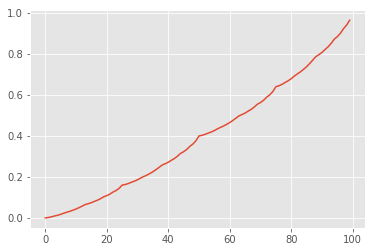

In [20]:
# Plot the value function for p_h=0.4;  your figure should match the final value function shown in the book.

# YOUR CODE HERE
plt.plot(V[:-1])

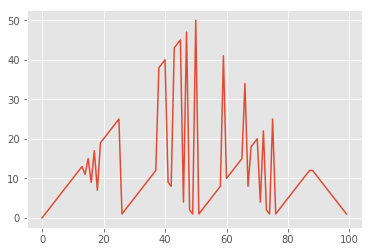

In [21]:
# Plot the policy function for p_h=0.4;  There are multiple optimal policies for this problem, so your figure
# does not have to match the figure in the book exactly (although they all share something in common.
# (another question in the homework sheet will ask you why.)

# YOUR CODE HERE
plt.plot(policy)

### Excerise 2 (10 Points):

Implement value iteration for any arbritary Gym environemnt provided there is a perfect model of the environment as an MDP. In order for a OpenAI Gym environment to have this perfect model it must have nS, nA, and P as attributes. Note that we have added a max iterations argument to this function. While this is not necessary, it ensures that we will never be stuck running forever due to a bad theta.

* **P:** Represents the transition probabilities of the environment. P[s][a] is the tuple (prob, next_state, reward, done)
* **nS:** Number of states in the environment
* **nA:** Number of actions in the environment

In [22]:
def gym_value_iteration(env, theta=1e-4, gamma=1.0, max_iterations=1000):
    """
    Args:
        env: OpenAI Gym environment which has P, nS, and nA as attributes
        theta: Threshold used to determine accuracy of estimation
        gamma: Discount factor
        max_iterations: Maximum number of value iterations to run
    Returns:
        A tuple (value_function, policy)
    """
    
    V = np.zeros(env.nS)
    policy = np.zeros(env.nS, dtype=np.int)
    
    
    # YOUR CODE HERE
    for iteration in range(max_iterations):
        delta = 0
        for s in range(env.nS):
            v = V[s]
            best_return = 0
            max_action = 0
            for action in range(env.nA):
                tuples = env.P[s][action]
                temp = 0
                
                for i in range(len(tuples)):
                    temp += tuples[i][0] * (tuples[i][2] + gamma * V[tuples[i][1]])
                
                if (temp > best_return):
                    best_return = temp
                    max_action = action
            
            V[s] = best_return
            policy[s] = max_action
            delta = max(delta, abs(v-V[s]))
            
        if (delta < theta):
            break       
                
    return V, policy

#### Test your implementation on the Frozen Lake environment

In [23]:
frozen_lake = FrozenLakeEnv()
V, policy = gym_value_iteration(frozen_lake)

optimal_policy = np.array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])

if (policy != optimal_policy).any():
    raise ValueError('Your computed policy is incorrect.  Try again.')
else:
    print('Your computed policy is correct!')

Your computed policy is correct!
